# Multinomial Bimodal Topic Model (Syntax-Context)

## 0a. Coding Info

* **Corpus**
    * Brown
    * McRae Norms
* **Parser**
    * SpaCy
* **Algorithm**
    * Collapsed Gibbs Sampling (based on Steyvers & Griffiths (2004); Roller & im Walde (2013))
* **Evaluation**
    * Precision @1/@5
    * Mean Average Precision (MAP) https://www.youtube.com/watch?v=pM6DJ0ZZee0&index=12&list=PLBv09BD7ez_6nqE9YU9bQXpjJ5jJ1Kgr9

## 0b. Procedure Description

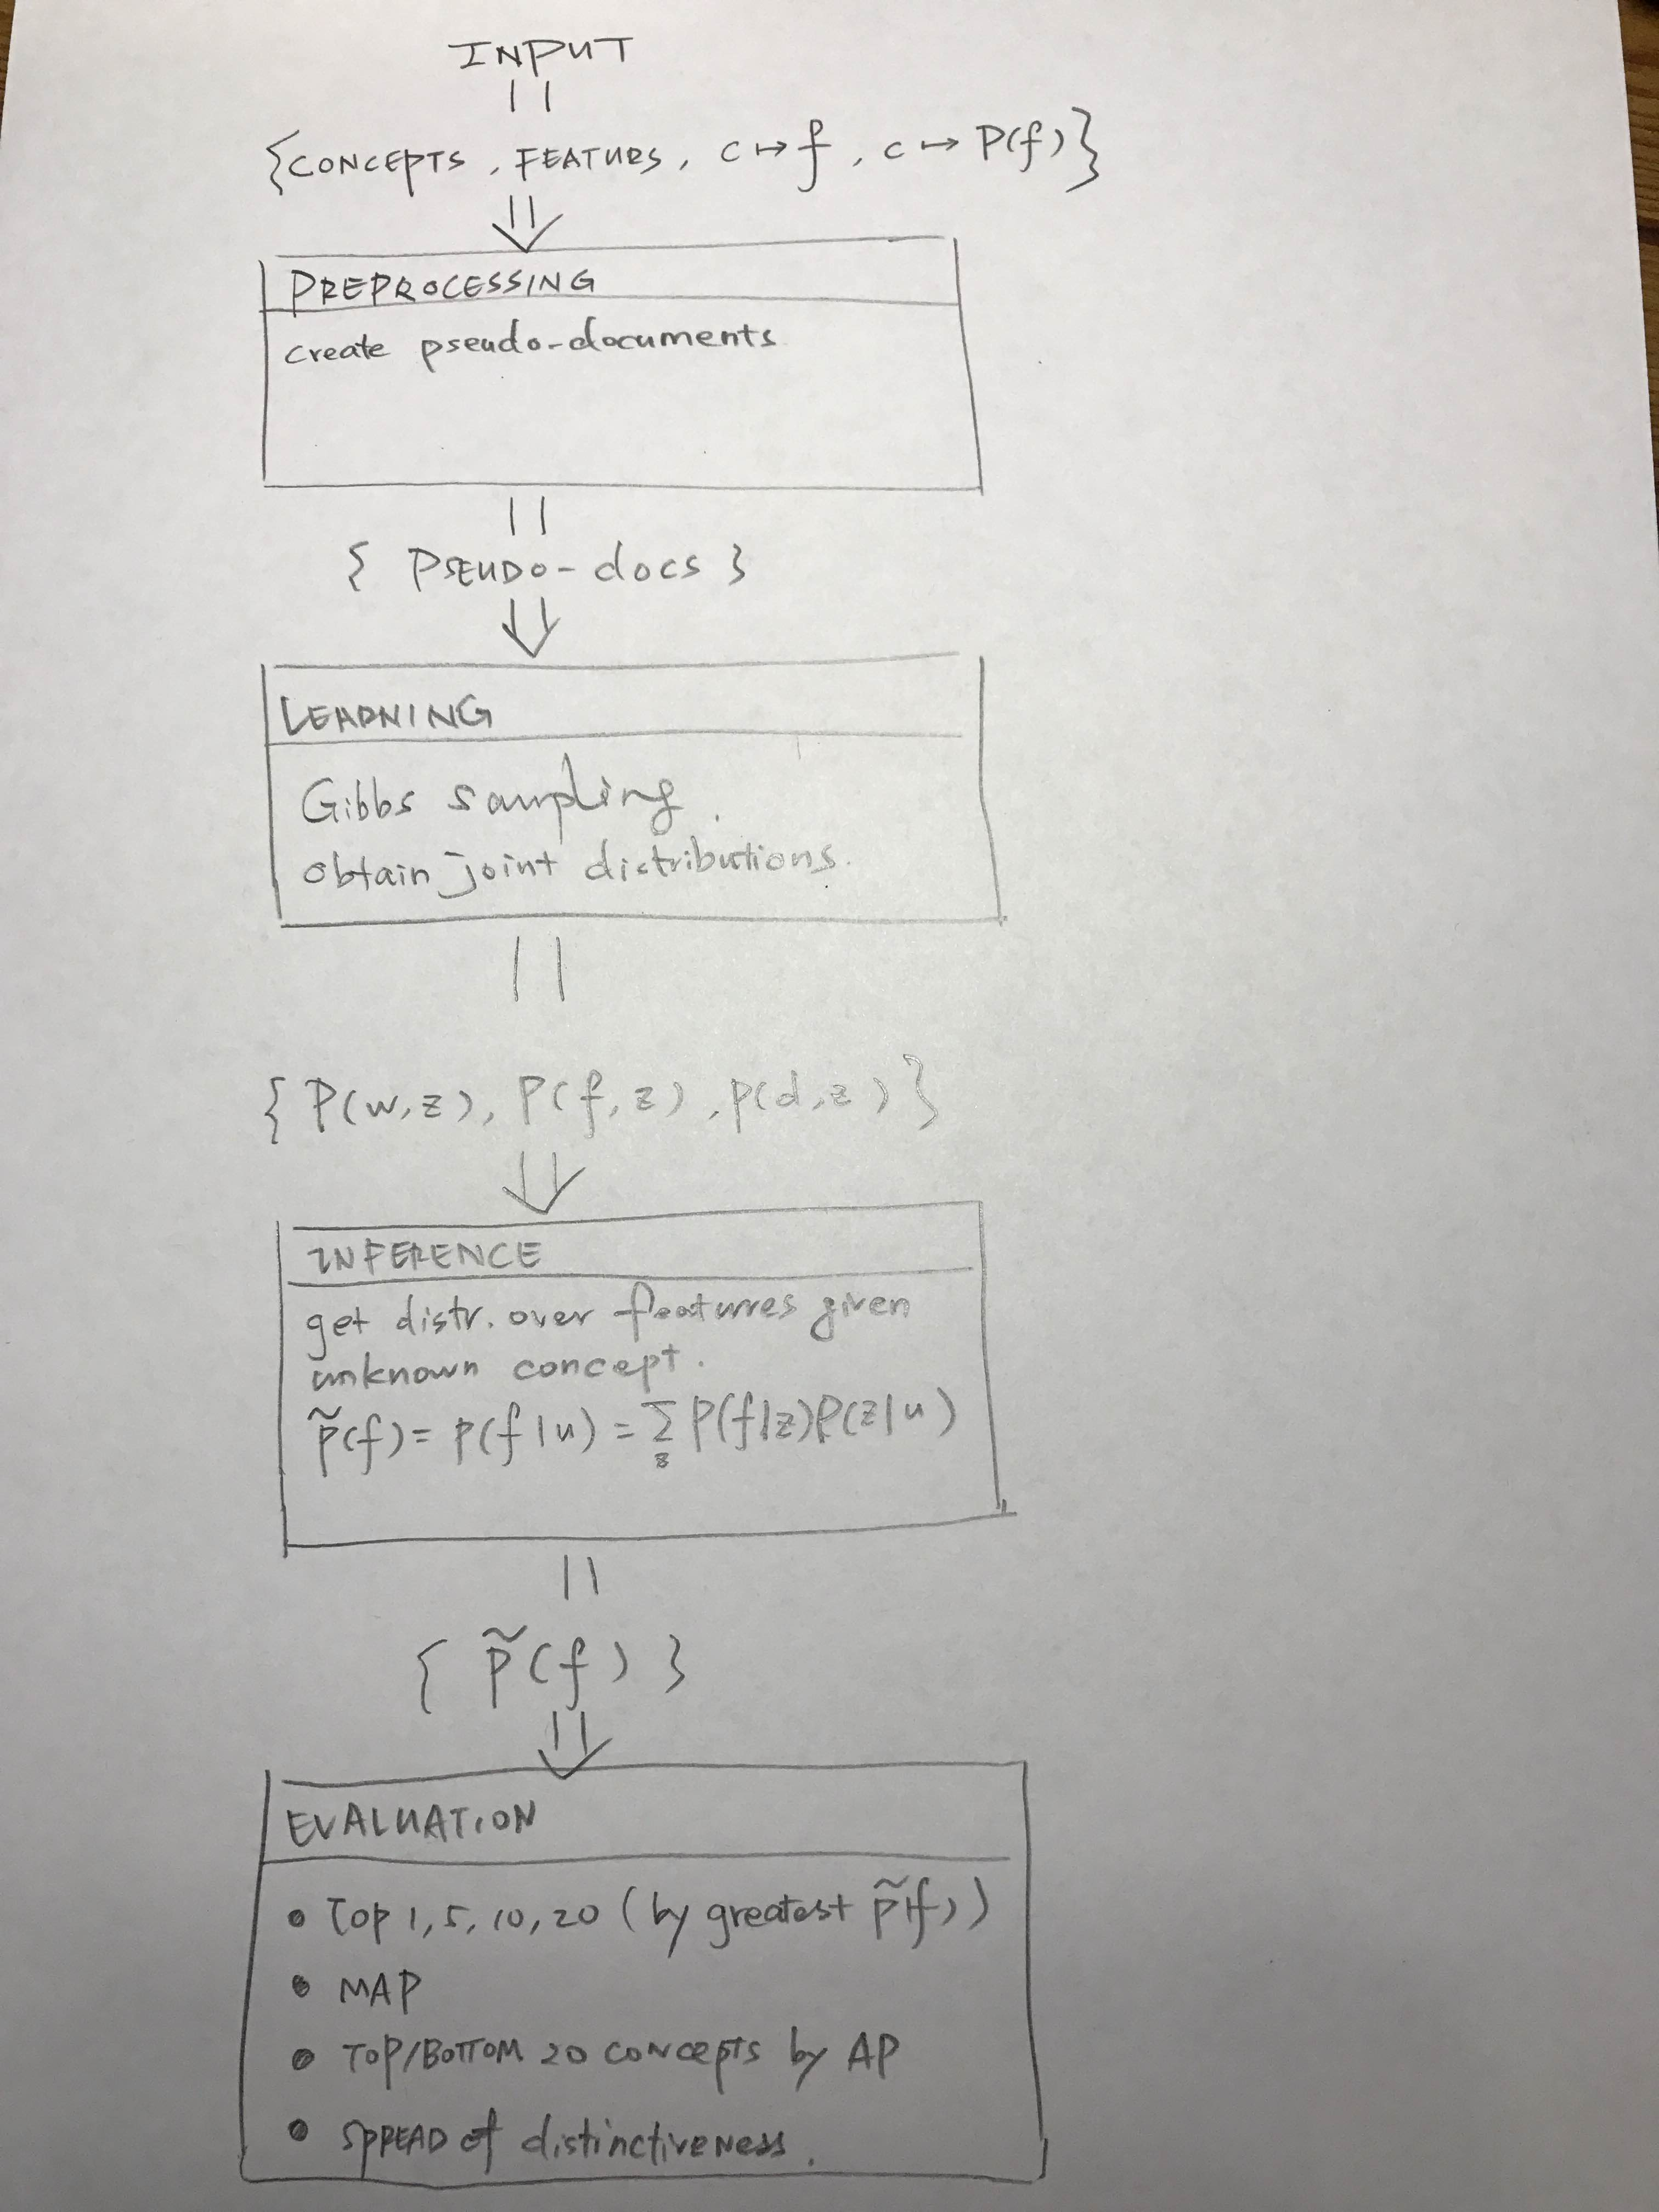

In [2]:
from IPython.display import display, Image
display(Image(filename="/Users/jacobsw/Desktop/UNIV/FALL_2016/LIN389C_RSCH_COMPLING/BAYESIAN/CODE_DRAFTS_2/FIGS/multinomial_syntax.png",width='50%'))

## 0c. Packages

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict, Counter
from __future__ import division
from itertools import chain
from copy import deepcopy
from operator import add
from functools import partial
from sklearn.metrics import average_precision_score

In [4]:
import os
os.environ["SPARK_HOME"] = "/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/"
import pyspark
from pyspark.context import SparkContext
sc = SparkContext()

## 0f. General Purpose Functions

In [9]:
def normalize(arr):
    return arr / arr.sum()

## I. Preprocessing

* **A**. Make Mappings $c\mapsto vr$ and $c\mapsto f$ (with all concepts);
* **B**. Train-Test Split (.8/.2, cv=5);
* **C**. Make Pseudo-Documents (with training concepts).

### A. Concept to Verb-Role/Feature Mappings

In [97]:
train_cpts = ['cat','dog','pig','car','bike','train']
test_cpts = ['squirrel','motorcycle']
features = ['an_animal','purrs','has_4_legs','barks','is_cute',                # animal features
            'used_for_transportation','honks','has_wheels','is_cool','is_big'] # transportation features
f2i = {f:i for i,f in enumerate(features)}
vrs = ['feed','pet','eat','meow','claw','woof','paw','hunn','clover',                # animal vrs
       'drive','repair','maintain','compact','park','ride','travel','take','ticket'] # transportation vrs.
vr2i = {vr:i for i,vr in enumerate(vrs)}
cpt2ft = {'cat':['an_animal','purrs','has_4_legs'],
          'dog':['an_animal','barks','has_4_legs'],
          'pig':['an_animal','is_cute','has_4_legs'],
          'car':['used_for_transportation','honks','has_wheels'],
          'bike':['used_for_transportation','is_cool','has_wheels'],
          'train':['used_for_transportation','is_big','has_wheels'],
          'squirrel':['an_animal','has_4_legs_','large_tail'],
          'motorcycle':['used_for_transportation','has_wheels','2_wheels']}
cpt2ftprob = {'cat':np.asarray([.33,.33,.33]),
              'dog':np.asarray([.33,.33,.33]),
              'pig':np.asarray([.33,.33,.33]),
              'car':np.asarray([.33,.33,.33]),
              'bike':np.asarray([.33,.33,.33]),
              'train':np.asarray([.33,.33,.33])}

In [146]:
c2vr_f = {'cat':{'vr':['feed','pet','eat','meow','claw'],
                 'f':['an_animal','an_animal','has_4_legs','has_4_legs','purrs']},
          'dog':{'vr':['feed','pet','eat','woof','paw'],
                 'f':['an_animal','an_animal','has_4_legs','has_4_legs','barks']},
          'pig':{'vr':['feed','pet','eat','hunn','clover'],
                 'f':['an_animal','an_animal','has_4_legs','has_4_legs','is_cute']},
          'car':{'vr':['drive','repair','maintain','compact','park'],
                 'f':['used_for_transportation','has_wheels','used_for_transportation','has_wheels','honks']},
          'bike':{'vr':['drive','repair','maintain','ride','travel'],
                  'f':['used_for_transportation','has_wheels','used_for_transportation','has_wheels','is_cool']},
          'train':{'vr':['drive','repair','maintain','take','ticket'],
                   'f':['used_for_transportation','has_wheels','used_for_transportation','has_wheels','is_big']},
          'squirrel':{'vr':['feed','pet','eat','claw','paw'],
                      'f':['an_animal','an_animal','has_4_legs','has_4_legs','is_cute']},
          'motorcycle':{'vr':['drive','repair','maintain','compact','travel'],
                        'f':['used_for_transportation','has_wheels','used_for_transportation','has_wheels','is_cool']}}

In [99]:
# FEATURE INDEXING CHECK
print features
print f2i

['an_animal', 'purrs', 'has_4_legs', 'barks', 'is_cute', 'used_for_transportation', 'honks', 'has_wheels', 'is_cool', 'is_big']
{'an_animal': 0, 'is_big': 9, 'honks': 6, 'has_4_legs': 2, 'barks': 3, 'is_cute': 4, 'is_cool': 8, 'has_wheels': 7, 'used_for_transportation': 5, 'purrs': 1}


In [100]:
# VR INDEXING CHECK
print vrs
print vr2i

['feed', 'pet', 'eat', 'meow', 'claw', 'woof', 'paw', 'hunn', 'clover', 'drive', 'repair', 'maintain', 'compact', 'park', 'ride', 'travel', 'take', 'ticket']
{'feed': 0, 'clover': 8, 'paw': 6, 'pet': 1, 'ride': 14, 'park': 13, 'meow': 3, 'drive': 9, 'woof': 5, 'compact': 12, 'maintain': 11, 'take': 16, 'hunn': 7, 'claw': 4, 'ticket': 17, 'repair': 10, 'eat': 2, 'travel': 15}


### C. Pseudo-Docs

In [101]:
def preproc_pseudo_doc(c2vr_f, cpts, topics=range(2), doc_size=100):
    vr_docs, ft_docs = [], []
    for cpt in cpts:
        cpt_vrs, cpt_fts = deepcopy(c2vr_f[cpt]['vr']), deepcopy(c2vr_f[cpt]['f'])
        vr_doc, ft_doc = [], []
        for i in range(doc_size):
            vr = np.random.choice(cpt_vrs,p=[1/len(cpt_vrs)]*len(cpt_vrs)); vr_doc.append(vr)
            f = np.random.choice(cpt_fts,p=[1/len(cpt_fts)]*len(cpt_fts)); ft_doc.append(f)
        vr_docs.append(vr_doc); ft_docs.append(ft_doc)
    for vr_doc,ft_doc in zip(vr_docs,ft_docs):
        for i,(vr,ft) in enumerate(zip(vr_doc,ft_doc)):
            sampled_topic = np.random.choice(topics)
            vr_doc[i] = (vr,sampled_topic)
            ft_doc[i] = (ft,sampled_topic)
    return vr_docs, ft_docs

In [102]:
train_docs = preproc_pseudo_doc(c2vr_f, train_cpts)
test_docs, _ = preproc_pseudo_doc(c2vr_f, test_cpts) # get rid of ft_docs cuz we don't know

In [103]:
# sanity check (train documents under 'cat'): PASS
print train_docs[0][0]; print
print train_docs[1][0]

[('eat', 1), ('pet', 1), ('feed', 0), ('claw', 1), ('eat', 0), ('eat', 0), ('feed', 0), ('eat', 0), ('pet', 1), ('eat', 1), ('pet', 0), ('pet', 1), ('eat', 1), ('pet', 1), ('feed', 1), ('eat', 1), ('eat', 0), ('feed', 1), ('pet', 1), ('eat', 1), ('meow', 0), ('feed', 1), ('meow', 1), ('pet', 0), ('pet', 0), ('feed', 0), ('meow', 0), ('pet', 1), ('meow', 0), ('pet', 0), ('pet', 0), ('feed', 0), ('eat', 0), ('claw', 1), ('eat', 1), ('pet', 1), ('feed', 1), ('claw', 0), ('meow', 1), ('pet', 1), ('meow', 1), ('meow', 0), ('feed', 0), ('feed', 0), ('eat', 1), ('meow', 0), ('feed', 0), ('pet', 0), ('feed', 0), ('feed', 1), ('eat', 1), ('claw', 0), ('feed', 1), ('claw', 0), ('claw', 1), ('meow', 0), ('pet', 1), ('pet', 1), ('feed', 0), ('meow', 1), ('meow', 0), ('meow', 1), ('meow', 0), ('feed', 1), ('meow', 1), ('eat', 0), ('feed', 0), ('meow', 1), ('eat', 0), ('pet', 0), ('meow', 1), ('feed', 1), ('eat', 1), ('meow', 0), ('feed', 0), ('meow', 0), ('feed', 1), ('meow', 0), ('eat', 1), ('claw

## II. Learning

In [104]:
def learn(train_docs, topics=range(2)):
    vr_docs, ft_docs = train_docs 
    W, F, D, T = len(vrs), len(features), len(vr_docs), len(topics)
    alpha, beta, gamma = 50/2, .001, .001
    alpha_arr = np.array([alpha for _ in range(T)]); Talpha_arr = np.array([alpha*T for _ in range(T)])
    beta_arr = np.array([beta for _ in range(T)]); Wbeta_arr = np.array([beta*W for _ in range(T)])
    gamma_arr = np.array([gamma for _ in range(T)]); Fgamma_arr = np.array([gamma*F for _ in range(T)])
    C_WT, C_FT, C_DT = np.zeros((W,T)), np.zeros((F,T)), np.zeros((D,T))
    vr_z_counts = reduce(add,[Counter(vr_doc) for vr_doc in vr_docs])
    f_z_counts = reduce(add,[Counter(ft_doc) for ft_doc in ft_docs])
    for (vr,z),vr_z_count in vr_z_counts.iteritems(): C_WT[vr2i[vr]][z] = vr_z_count
    for (f,z),f_z_count in f_z_counts.iteritems(): C_FT[f2i[f]][z] = f_z_count
    for d,doc in enumerate(vr_docs):
        d_z_counts = Counter([z for vr,z in doc])
        for z in range(T):
            C_DT[d][z] = d_z_counts[z]
    assert C_WT.sum()==C_FT.sum()==C_DT.sum()
    print 'BEFORE:'
    print pd.DataFrame(C_WT,index=vrs); print
    print pd.DataFrame(C_FT,index=features); print
    print pd.DataFrame(C_DT); print
    print C_WT.sum(), C_FT.sum(), C_DT.sum()
    print
    # define sampling functions (locally defined to avoid passing large matrices.
    def sample_topic(vr_i,f_i,d): # defined locally to avoid passing around big matrices.
        P_num_arr = (C_WT[vr_i,:]+beta_arr) * (C_FT[f_i,:]+gamma_arr) * (C_DT[d,:]+alpha_arr)
        P_denom_arr = (np.apply_along_axis(sum,0,C_WT)+Wbeta_arr) * \
                      (np.apply_along_axis(sum,0,C_FT)+Fgamma_arr) * \
                      (T * (C_DT[d,:].sum()+T*alpha))
        P = normalize(P_num_arr / P_denom_arr)
        return np.random.choice(np.array(topics),p=P)    
    def gibbs(n_iters=1000, verbose_freq=200): 
        for e in range(n_iters):
            if e!=0 and e%verbose_freq==0: print "  ... running %dth iteration" % e
            for d,(vr_doc,ft_doc) in enumerate(zip(vr_docs,ft_docs)):
                for (vr,z),(f,_) in zip(vr_doc,ft_doc): # a (vr,f) pair have the same topic.
                    if C_WT[vr2i[vr]][z]==0 or C_FT[f2i[f]][z]==0 or C_DT[d][z]==0: continue
                    C_WT[vr2i[vr]][z] -= 1
                    C_FT[f2i[f]][z] -= 1
                    C_DT[d][z] -= 1
                    new_z = sample_topic(vr2i[vr],f2i[f],d)
                    C_WT[vr2i[vr]][new_z] += 1
                    C_FT[f2i[f]][new_z] += 1
                    C_DT[d][new_z] += 1   
    gibbs()
    print; print 'AFTER:'
    print pd.DataFrame(C_WT,index=vrs); print
    print pd.DataFrame(C_FT,index=features); print
    print pd.DataFrame(C_DT); print
    print C_WT.sum(), C_FT.sum(), C_DT.sum()
    
    return C_WT, C_FT, C_DT

In [105]:
%%time
C_WT, C_FT, C_DT = learn(pseudo_docs)

BEFORE:
             0     1
feed      22.0  32.0
pet       33.0  33.0
eat       38.0  33.0
meow      13.0   8.0
claw       8.0  12.0
woof       6.0  10.0
paw       12.0  10.0
hunn       7.0  11.0
clover     6.0   6.0
drive     24.0  30.0
repair    39.0  21.0
maintain  31.0  28.0
compact   11.0   6.0
park      10.0   8.0
ride       8.0  14.0
travel    12.0  14.0
take       8.0  13.0
ticket    12.0  11.0

                            0     1
an_animal                54.0  60.0
purrs                    11.0  14.0
has_4_legs               63.0  59.0
barks                    10.0  11.0
is_cute                   7.0  11.0
used_for_transportation  60.0  64.0
honks                     9.0   5.0
has_wheels               70.0  57.0
is_cool                   9.0   9.0
is_big                    7.0  10.0

      0     1
0  52.0  48.0
1  48.0  52.0
2  45.0  55.0
3  57.0  43.0
4  53.0  47.0
5  45.0  55.0

600.0 600.0 600.0

  ... running 200th iteration
  ... running 400th iteration
  ... running 600

## III. Inference

* Gibbs2 (Yao et al. 2009)

### A. Learn $C^{DT}$ (i.e. Joint Distr. for Docs and Topics) for Test Document 

In [106]:
# sanity check (train documents under 'squirrel'): PASS
print test_docs[0]; print
print test_docs[1]

[('feed', 0), ('eat', 1), ('claw', 1), ('paw', 0), ('feed', 0), ('paw', 1), ('paw', 1), ('eat', 1), ('feed', 1), ('eat', 0), ('pet', 1), ('claw', 1), ('eat', 0), ('pet', 0), ('feed', 0), ('pet', 0), ('eat', 1), ('paw', 1), ('feed', 0), ('eat', 1), ('paw', 0), ('claw', 0), ('paw', 1), ('eat', 0), ('pet', 0), ('paw', 1), ('claw', 0), ('eat', 1), ('claw', 0), ('paw', 0), ('claw', 0), ('paw', 0), ('claw', 0), ('paw', 0), ('paw', 1), ('pet', 1), ('pet', 1), ('eat', 0), ('claw', 1), ('pet', 1), ('paw', 0), ('eat', 0), ('eat', 1), ('pet', 0), ('feed', 0), ('feed', 0), ('claw', 0), ('eat', 1), ('claw', 1), ('feed', 1), ('feed', 1), ('paw', 1), ('eat', 1), ('pet', 1), ('pet', 1), ('pet', 1), ('feed', 1), ('paw', 1), ('paw', 1), ('paw', 0), ('eat', 1), ('feed', 0), ('pet', 0), ('eat', 0), ('feed', 1), ('claw', 0), ('feed', 1), ('pet', 1), ('paw', 0), ('eat', 0), ('pet', 0), ('feed', 0), ('paw', 1), ('pet', 1), ('eat', 0), ('paw', 0), ('pet', 0), ('eat', 1), ('eat', 0), ('paw', 0), ('paw', 0), ('

In [107]:
print C_WT.shape, C_FT.shape, C_DT.shape

(18, 2) (10, 2) (6, 2)


In [110]:
def infer(C_WT, C_FT, C_DT, test_docs, topics=range(2)): # we'll combine learn & infer later, passing topic only once.
    vr_docs = test_docs
    W, D, T = len(vrs), len(vr_docs), len(topics)
    alpha, beta = 50/2, .001
    alpha_arr = np.array([alpha for _ in range(T)]); Talpha_arr = np.array([alpha*T for _ in range(T)])
    beta_arr = np.array([beta for _ in range(T)]); Wbeta_arr = np.array([beta*W for _ in range(T)])
    C_WT_test, C_DT_test = np.zeros((W,T)), np.zeros((D,T))
    vr_z_counts = reduce(add,[Counter(vr_doc) for vr_doc in vr_docs])
    for (vr,z),vr_z_count in vr_z_counts.iteritems(): C_WT_test[vr2i[vr]][z] = vr_z_count
    for d,doc in enumerate(vr_docs):
        d_z_counts = Counter([z for vr,z in doc])
        for z in range(T):
            C_DT_test[d][z] = d_z_counts[z]
    assert C_WT.sum()==C_DT.sum()
    print 'BEFORE:'
    print pd.DataFrame(C_WT_test,index=vrs); print
    print pd.DataFrame(C_DT_test); print
    print C_WT_test.sum(), C_DT_test.sum()
    print
    def sample_topic(vr_i,d): # NB: we are sampling from learned C_WT now!!
        P_num_arr = (C_WT[vr_i,:]+beta_arr) * (C_DT_test[d,:]+alpha_arr)
        P_denom_arr = (np.apply_along_axis(sum,0,C_WT)+Wbeta_arr) * \
                      (T * (C_DT_test[d,:].sum()+T*alpha))
        P = normalize(P_num_arr / P_denom_arr)
        return np.random.choice(np.array(topics),p=P)  
    def gibbs(n_iters=1000, verbose_freq=200): 
        for e in range(n_iters):
            if e!=0 and e%verbose_freq==0: print "  ... running %dth iteration" % e
            for d,vr_doc in enumerate(vr_docs):
                for vr,z in vr_doc: 
                    if C_WT_test[vr2i[vr]][z]==0 or C_DT_test[d][z]==0: continue
                    C_WT_test[vr2i[vr]][z] -= 1
                    C_DT_test[d][z] -= 1
                    new_z = sample_topic(vr2i[vr],d)
                    C_WT_test[vr2i[vr]][new_z] += 1
                    C_DT_test[d][new_z] += 1
    gibbs()
    print; print 'AFTER:'
    print pd.DataFrame(C_WT_test,index=vrs); print
    print pd.DataFrame(C_DT_test); print
    print C_WT_test.sum(), C_DT_test.sum()
    
    return C_WT_test, C_DT_test

In [111]:
%%time
C_WT_test, C_DT_test = infer(C_WT, C_FT, C_DT, test_docs)

BEFORE:
             0     1
feed      11.0   6.0
pet       10.0  11.0
eat       10.0  13.0
meow       0.0   0.0
claw       8.0   5.0
woof       0.0   0.0
paw       12.0  14.0
hunn       0.0   0.0
clover     0.0   0.0
drive     10.0   9.0
repair    14.0   7.0
maintain   8.0  12.0
compact    8.0  12.0
park       0.0   0.0
ride       0.0   0.0
travel    11.0   9.0
take       0.0   0.0
ticket     0.0   0.0

      0     1
0  51.0  49.0
1  51.0  49.0

200.0 200.0

  ... running 200th iteration
  ... running 400th iteration
  ... running 600th iteration
  ... running 800th iteration

AFTER:
             0     1
feed       0.0  17.0
pet        0.0  21.0
eat        0.0  23.0
meow       0.0   0.0
claw       0.0  13.0
woof       0.0   0.0
paw        0.0  26.0
hunn       0.0   0.0
clover     0.0   0.0
drive     19.0   0.0
repair    21.0   0.0
maintain  20.0   0.0
compact   20.0   0.0
park       0.0   0.0
ride       0.0   0.0
travel    20.0   0.0
take       0.0   0.0
ticket     0.0   0.0

       0

### B. Predicting Features for Test Docs

* Compute the probability of each feature $f$ given $u$ by $$P(f\mid u) = \sum_{z\in T}P(f\mid z)P(z\mid u_d)$$ over all topics $z\in T$ where $u_d$ is the test document corresponding to $u$.

In [122]:
def p_f_given_z(f, z): return C_FT[f2i[f]][z] / C_FT[:,z].sum()
def p_z_given_d(z, d): return C_DT_test[d][z] / C_DT_test[d,:].sum()
def predict(d, topics=range(2)):
    return np.array([sum(p_f_given_z(f,z)*p_z_given_d(z,d) for z in topics) for f in features])

In [123]:
# d=0: squirrel; d=1: motorcycle
f_squirrel = predict(d=0)
f_motorcycle = predict(d=1)

## IV. Evaluation

In [157]:
def evaluate_prec(u, f_u):
    prec_1, prec_5 = None, None
    true_fts = c2vr_f[u]['f']
    pred_fts_desc = np.argsort(f_u)[::-1]
    pred_1_ft = features[pred_fts_desc[0]]
    pred_5_fts = map(lambda f_i:features[f_i], pred_fts_desc[:5])
    prec_1 = 1 if pred_1_ft in true_fts else 0
    prec_5 = sum(1 if pred_ft in true_fts else 0 for pred_ft in pred_5_fts) / 5
    print "Unknown Concept: %s" % u
    print "Precision @1 Evaluation: %.6f%%" % (prec_1*100)
    print "Precision @5 Evaluation: %.6f%%" % (prec_5*100)

In [158]:
evaluate_prec('squirrel', f_squirrel); print
evaluate_prec('motorcycle', f_motorcycle)

Unknown Concept: squirrel
Precision @1 Evaluation: 100.000000%
Precision @5 Evaluation: 60.000000%

Unknown Concept: motorcycle
Precision @1 Evaluation: 100.000000%
Precision @5 Evaluation: 60.000000%


In [159]:
def evaluate_ap(u, f_u):
    true_ftbin = np.array([1 if ft in c2vr_f[u]['f'] else 0 for ft in features])
    print "Unknown Concept: %s" % u
    print "AP: %.6f%%" % (average_precision_score(true_ftbin, f_u)*100)

In [160]:
evaluate_ap('squirrel', f_squirrel); print
evaluate_ap('motorcycle', f_motorcycle)

Unknown Concept: squirrel
AP: 85.000000%

Unknown Concept: motorcycle
AP: 100.000000%
